In this notebook we explore the VarQITE module in qiskit for imaginary time evolution. We use the Hamiltonian of Spinless, one-dimensional, periodic tight binding lattice model. We write it in term sof Pauli operators and evolve a trial states for some imaginary time.  

### 1. Imports 

In [1]:
import numpy as np
from qiskit import *
from qiskit.quantum_info import Operator, Pauli, SparsePauliOp, Statevector
from tabulate import tabulate
from itertools import combinations
import math, cmath, pylab, time
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.algorithms import TimeEvolutionProblem, VarQITE, SciPyImaginaryEvolver

from qiskit.algorithms.gradients import ReverseEstimatorGradient, ReverseQGT

### Hamiltonian  
We use the Jordan Wigner Trnsformation and SparsePauliOp to write the Hamiltonian operator

In [2]:
def tb0_JW(N,e,t) : 
    strings = []
    opt = SparsePauliOp.from_sparse_list([("I", [0], 0)], num_qubits=N)  
    for k in range(N) : 
        a0='I'*(N)
        a1 = 'I'*(k)+'Z' +'I'*(N-k-1)

        b0='I'*N
        b0_list = list(b0)
        b0_list[k] = 'X'
        b0_list[(k+1)%N] = 'X'
        new_b0 = ''.join(b0_list)

        b1='I'*N
        b1_list = list(b0)
        b1_list[k] = 'Y'
        b1_list[(k+1)%N] = 'Y'
        new_b1 = ''.join(b1_list)

        strings.append([a0,a1,new_b0,new_b1])
        val = 1
        if N==2 and k==1 : 
            val = 0
        opt += SparsePauliOp.from_list([(a0, 0.5*e[k]), (a1, -0.5*e[k]),(new_b0, 0.5*t*val),(new_b1, 0.5*t*val)])
    return opt  


In [3]:
N=2
e=[1]*N
t=7
H_op = tb0_JW(N,e,t)

exp_time = 5.0
aux_ops = [H_op]
evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)

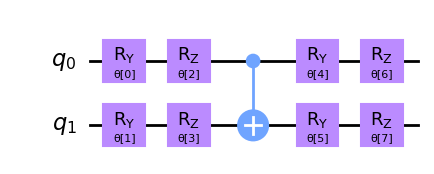

In [4]:
ansatz = EfficientSU2(H_op.num_qubits, reps=1)
ansatz.decompose().draw('mpl')

In [5]:
init_param_values={}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]]=np.pi/2

In [6]:
init_state = Statevector(ansatz.assign_parameters(init_param_values))

In [7]:
var_principle = ImaginaryMcLachlanPrinciple()

In [8]:
start_time = time.time()

var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())

evolution_result = var_qite.evolve(evolution_problem)


end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time, " seconds")

Elapsed time:  120.74094939231873  seconds


In [9]:
evolution_problem = TimeEvolutionProblem(H_op, exp_time, initial_state=init_state, aux_operators=aux_ops)
exact_evol = SciPyImaginaryEvolver(num_timesteps=501)
sol = exact_evol.evolve(evolution_problem)

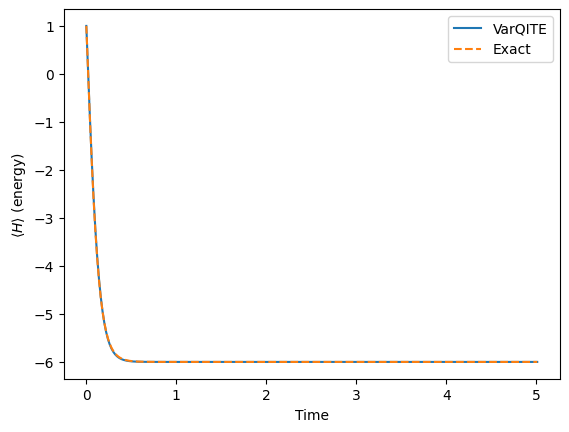

In [10]:
h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])

exact_h_exp_val = sol.observables[0][0].real

times = evolution_result.times
pylab.plot(times, h_exp_val, label= "VarQITE")
pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

In [11]:
print("Calculated Ground state energy", h_exp_val[-1])
print("Exact Ground state energy",exact_h_exp_val[-1])

Calculated Ground state energy -6.000000000000002
Exact Ground state energy -6.0


In [12]:
start_time = time.time()

var_principle = ImaginaryMcLachlanPrinciple(qgt = ReverseQGT() , gradient = ReverseEstimatorGradient())
evolution_problem = TimeEvolutionProblem(H_op, exp_time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
evolution_result_eff = var_qite.evolve(evolution_problem)

end_time = time.time()
elapsed_time = end_time - start_time

print("Elapsed time: ", elapsed_time, " seconds")

Elapsed time:  79.6514642238617  seconds


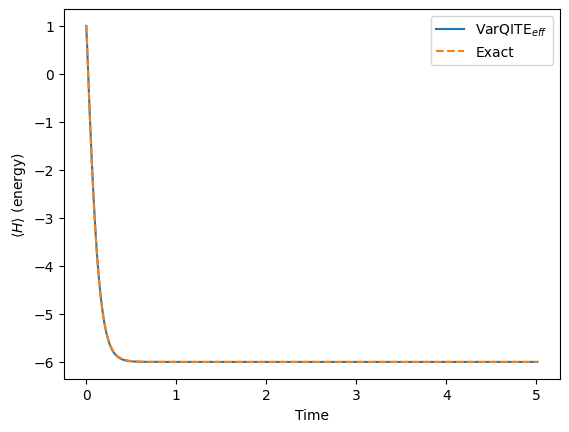

In [13]:
h_exp_val_eff = np.array([ele[0][0] for ele in evolution_result_eff.observables])

exact_h_exp_val_eff = sol.observables[0][0].real

times = evolution_result_eff.times
pylab.plot(times, h_exp_val_eff, label= r"VarQITE$_{eff}$")
pylab.plot(times, exact_h_exp_val_eff , label= "Exact",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

In [14]:
print("Ground state energy", h_exp_val_eff[-1])

Ground state energy -6.000000000000002


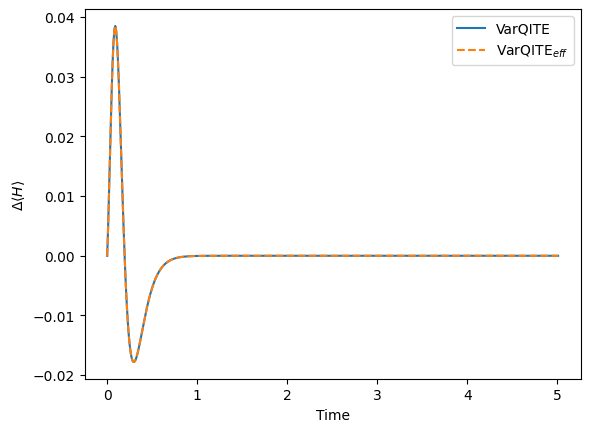

In [15]:
pylab.plot(times, (h_exp_val-exact_h_exp_val), label= "VarQITE")
pylab.plot(times, (h_exp_val_eff-exact_h_exp_val_eff), label= r"VarQITE$_{eff}$",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\Delta \langle H \rangle$")
pylab.legend(loc="upper right");

### References  
1. [Variational Quantum Time Evolution - Qiskit Documentation](https://qiskit.org/documentation/tutorials/algorithms/11_VarQTE.html)  
2. [Yuan et al. Quantum 3, 191](https://quantum-journal.org/papers/q-2019-10-07-191/)